### (1) Import

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

### (2) hyperparameter
#### text
- sequence_lenght : 문장의 길이
- input_size : word embedding vector 의 size
- hidden_size : hidden state vector 의 size
- num_layers : 레이어 개수

In [3]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [4]:
device = torch.device("cpu")

### (3) MNIST train, test dataset 가져오기
- Multi-layered RNN
- Many to one

In [6]:
# train
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)

# test
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(),
                        target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### (4) 대략적인 데이터 형태

mnist_train 길이 :  60000
mnist_test 길이 :  10000
image data 형태 :  torch.Size([1, 28, 28])
label :  5


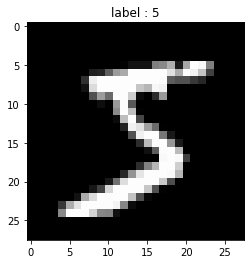

In [7]:
print("mnist_train 길이 : ", len(mnist_train))
print("mnist_test 길이 : ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태 : ", image.size())
print("label : ", label)

# 그리기
img = image.numpy() # image 타입을 numpy 로 변환(1, 28, 28)
plt.title("label : %d" % label)
plt.imshow(img[0], cmap="gray")
plt.show()

### (5) 데이터 로드 함수

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True) # batch_size 만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

[0]
한 번에 로드되는 데이터 크기 :  100


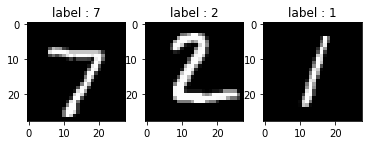

[1]
한 번에 로드되는 데이터 크기 :  100


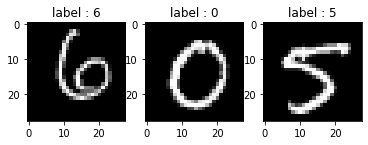

[2]
한 번에 로드되는 데이터 크기 :  100


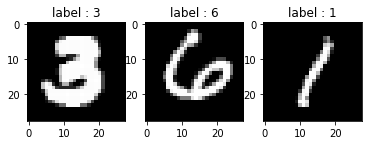

[3]
한 번에 로드되는 데이터 크기 :  100


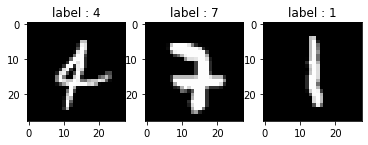

[4]
한 번에 로드되는 데이터 크기 :  100


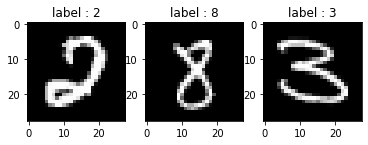

[5]
한 번에 로드되는 데이터 크기 :  100


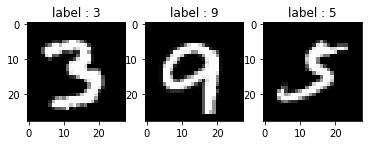

In [11]:
n = 3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader):
  if i > 5:
    break
  
  print("[%d]" % i)
  print("한 번에 로드되는 데이터 크기 : ", len(imgs))

  # 그리기
  for j in range(n):
    img = imgs[j].numpy() # image 타입을 numpy로 변환(1, 28, 28)
    img = img.reshape((img.shape[1], img.shape[2])) # (1, 28, 28) -> (28, 28)

    plt.subplot(1, n, j+1) # (1, 3) 형태 플랏의 j번째 자리에 그리겠다
    plt.imshow(img, cmap="gray")
    plt.title("label : %d" % labels[j])
  plt.show()

### (6) 모델 선언
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM
- LSTM 쓰면서 class 이름을 RNN 이라고 많이 쓴다.
- batch_first=True

In [13]:
# RNN
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    # 128 차원을 10차원(0~9까지를 나타냄 : MNIST 이므로)으로
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # ---
    # input tensor : (batch_size, seq_length, input_size)
    # x : (100, 28, 28)
    # print("x : ", x.shape)

    # ---
    # hidden state tensor : (# of layers, batch_size, hidden_size)
    # h : (2, 100, 128)
    # 첫번째 time-step 에서는 입력이 없으므로 0으로 채울 것이다.
    # x의 shape 에서 첫 번째 shape 이 batch_size 이다.
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    # ---
    # forward propagate LSTM
    # output tensor : (batch_size, seq_length, hidden_size)
    # out : (100, 28, 128)
    # print("out : ", out.shape)
    out, _ = self.lstm(x, (h0, c0))

    # ---
    # 28번째 output layer : (batch_size, hidden_size)
    # out[:, -1, :] : (100, 128)
    # print("out[-1]: ", out[:, -1, :].shape)
    out = self.fc(out[:, -1, :])

    # y^ : (batch_size, num_classes)
    # y_pred : (100, 10)
    # print("out : ", out.shape)
    return out

In [14]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [16]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader):
    # x : (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
    img = imgs
    img = img.reshape(-1, sequence_length, input_size).to(device)

    # y : (batch_size, num_classes)
    label = labels.to(device) # y # Variable(labels)
    # label = Variable(labels).cpu()

    # Forward prop
    output = imodel(img) # (batch_size, num_classes)
    _, output_index = torch.max(output, 1) # (batch_size, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  
  return (100 * correct / total).numpy() # tensor -> numpy

In [18]:
print("Accuracy of Test Data : %.2f" % ComputeAccr(test_loader, model))
# train_loader 를 넣어도 10 전후 값이 나온다. 아직 학습이 되지 않았기 때문이며 이를 통해 학습을 한 데이터인지 아닌지 확인할 수 있다.

Accuracy of Test Data : 9.80


### (7) loss, optimizer

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### (8) 학습

In [20]:
total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, [imgs, labels] in enumerate(train_loader):
    # x : (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
    # -1을 넣음으로써 batch_size, 1 이 batch_size 로 된다. (알아서 해줘라)
    img = imgs
    img = img.reshape(-1, sequence_length, input_size).to(device)

    # y : (batch_size, num_classes)
    label = labels.to(device) # y # Variable(labels)

    # Forward prop
    outputs = model(img)
    loss = loss_func(outputs, label)

    # Backward prop & optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print("Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}, Accr : {:.2f}"
      .format(epoch+1, num_epochs, i+1, total_step, loss.item(), ComputeAccr(test_loader, model)))

Epoch [1/2], Step [100/600], Loss : 0.7788, Accr : 79.75
Epoch [1/2], Step [200/600], Loss : 0.2515, Accr : 90.84
Epoch [1/2], Step [300/600], Loss : 0.2527, Accr : 93.22
Epoch [1/2], Step [400/600], Loss : 0.1324, Accr : 95.84
Epoch [1/2], Step [500/600], Loss : 0.0721, Accr : 95.78
Epoch [1/2], Step [600/600], Loss : 0.0876, Accr : 95.62
Epoch [2/2], Step [100/600], Loss : 0.0850, Accr : 97.87
Epoch [2/2], Step [200/600], Loss : 0.2392, Accr : 97.05
Epoch [2/2], Step [300/600], Loss : 0.1270, Accr : 97.19
Epoch [2/2], Step [400/600], Loss : 0.1009, Accr : 97.17
Epoch [2/2], Step [500/600], Loss : 0.1355, Accr : 97.76
Epoch [2/2], Step [600/600], Loss : 0.1187, Accr : 97.82


### (9) Test

In [21]:
print("Accuracy of Test Data : %.2f" % ComputeAccr(test_loader, model))

Accuracy of Test Data : 97.82


### 학습된 파라미터 로드

In [22]:
# 먼저, 폴더 만든 후에 아래 코드 실행
netname = "./nets/rnn_weight.pkl"
torch.save(model, netname)

model = torch.load(netname)
print("Accuracy of Test Data : %.2f" % ComputeAccr(test_loader, model))

Accuracy of Test Data : 97.82
